In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.stats import stats

sns.set_style('white')
%matplotlib inline

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

pal = sns.cubehelix_palette(20, rot=-.25, light=0.7)

In [2]:
df_rel_sort_list = pickle.load(open('pickle_files/rel_sort_lod_list.pkl', 'rb'))
df_abs_sort_list = pickle.load(open('pickle_files/abs_sort_lod_list.pkl', 'rb'))

df_pseudo_rel_sort_list = pickle.load(open('pickle_files/pseudo_rel_sort_lod_list.pkl', 'rb'))
df_pseudo_abs_sort_list = pickle.load(open('pickle_files/pseudo_abs_sort_lod_list.pkl', 'rb'))

df_col_names_list = pickle.load(open('pickle_files/col_names_lod_list.pkl', 'rb'))
df_metadata = pickle.load(open('pickle_files/metadata_all.pkl', 'rb'))

In [3]:
# Read in the data file
df=pd.read_csv('data_files/20210810_2 -  Quantification Cq Results_0.csv')

# Replace all Nan values for Cq with 40
df['Cq'].fillna(40,inplace=True)

# Define column names
samples=[395, 185, 167, 322, 193, 419, 145, 199, 
         272, 343, 232, 388, 274, 238, 298, 180, 
         243, 408, 241, 207, 214, 302, 'H20', 'H20',
         348, 349, 350, 351, 352, 353, 354, 356]

# Define Rows used
rows=['A','B','C','D','E','F','G','H']

In [4]:
df_klebsiella = pd.DataFrame(columns=['Cq'])

for index, row in enumerate(rows):
    df_klebsiella.loc[index] = df.loc[df['Well'].str.contains(row), 'Cq'].values.tolist()[0]
    df_klebsiella.loc[index+8] = df.loc[df['Well'].str.contains(row), 'Cq'].values.tolist()[1]
    df_klebsiella.loc[index+16] = df.loc[df['Well'].str.contains(row), 'Cq'].values.tolist()[2]
    df_klebsiella.loc[index+24] = df.loc[df['Well'].str.contains(row), 'Cq'].values.tolist()[3]
    
df_klebsiella.sort_index(inplace=True)
df_klebsiella['Sample'] = samples
df_klebsiella['Type'] = ['+']*22+['H20']*2+['-']*8
df_klebsiella.set_index('Sample', inplace=True)
df_klebsiella['Copies/uL'] = 2**(22.4-df_klebsiella['Cq'])*1000*10

df_klebsiella.head()

Cq Type      Copies/uL
Sample                               
395     19.049029    +  102033.479576
185     19.263251    +   87954.014349
167     19.521698    +   73528.399141
322     21.057104    +   25365.999011
193     40.000000    +       0.050335

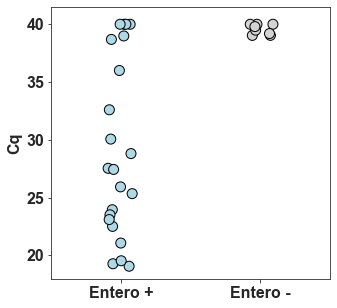

In [5]:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

sns.stripplot(x='Type', y='Cq', data=df_klebsiella, order=['+', '-'], s=10, palette=['lightblue','lightgrey'], edgecolor='k', linewidth=1)
ax1.set_ylabel('Cq', fontsize=16, fontweight='bold')
ax1.set_xlabel('')
ax1.set_xticklabels(['Entero +','Entero -'], fontsize=16, fontweight='bold')
fig.savefig('Kleb_Entero_stripplot.pdf', bbox_inches='tight', transparent=True)

In [6]:
df_klebsiella = df_klebsiella.merge(df_metadata[['Weight (mL)']], left_index=True, right_index=True)
df_klebsiella['Weight (mL)'] = df_klebsiella['Weight (mL)'].astype('float')
df_klebsiella['Copies/mL'] = df_klebsiella['Copies/uL']*100/df_klebsiella['Weight (mL)']

In [7]:
df_merge = df_klebsiella.merge(df_abs_sort_list[4][['ASV255']], left_index=True, right_index=True)
df_merge['Log Copies/mL'] = np.log10(df_merge['Copies/mL']+1)
df_merge['Log Entero'] =  np.log10(df_merge['ASV255']+1)

In [8]:
df_merge.head()

Cq Type     Copies/uL  Weight (mL)     Copies/mL        ASV255  \
145  22.497330    +   9347.610433      1.77000  5.281136e+05  5.256522e+06   
167  19.521698    +  73528.399141      1.27760  5.755197e+06  1.124314e+08   
180  32.594624    +      8.533209      1.84510  4.624795e+02  3.504757e+05   
185  19.263251    +  87954.014349      0.93814  9.375361e+06  1.537657e+08   
193  40.000000    +      0.050335      1.00000  5.033523e+00  1.839212e+07   

     Log Copies/mL  Log Entero  
145       5.722728    6.720699  
167       6.760060    8.050888  
180       2.666031    5.544659  
185       6.971988    8.186860  
193       0.780571    7.264632

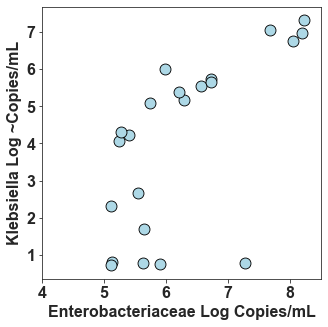

In [9]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

sns.scatterplot(ax=ax1, x='Log Entero', y='Log Copies/mL', data=df_merge, s=120, color='lightblue', edgecolor='k')

ax1.set_xlim(4,8.5)

ax1.set_ylabel('Klebsiella Log ~Copies/mL', fontsize=16, fontweight='bold')
ax1.set_xlabel('Enterobacteriaceae Log Copies/mL', fontsize=16, fontweight='bold')
fig.savefig('Kleb_Entero_scatter.pdf', bbox_inches='tight', transparent=True)

In [10]:
_df = df_merge[(df_merge['Cq']<37)&(df_merge['Type']=='+')]

x = _df['Log Copies/mL'].tolist()
y = _df['Log Entero'].tolist()

stats.pearsonr(x,y)

(0.8827247048393103, 5.968164622358843e-06)